In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/PhD/MPBP_reframe/MatrixProductBP.jl/tmp`


In [2]:
using Revise
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Statistics, Random, LinearAlgebra, TensorTrains, SparseArrays, Distributions
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using ProgressMeter: @showprogress
using TensorTrains: summary_compact
using Plots, LaTeXStrings

## Finite graph

In [3]:
seed = 1
rng = MersenneTwister(seed)

T = 10
N = 5
gg = barabasi_albert(N, 2, 1; rng, complete=true)
g = IndexedBiDiGraph(gg)

β = 0.5
h = 0.2
m⁰ = 0.7
K = 100
σ = 1/100
P = 2.0

J = zeros(nv(g),nv(g))
for i in axes(J)[1], j in axes(J)[2]
    j>i && continue
    if has_edge(gg,i,j)
        # J[i,j] = 2*rand(rng)-1
        # J[i,j] = rand(rng)
        J[i,j] = 1.0
        J[j,i] = J[i,j]
    end
end

ϕᵢ = [t == 0 ? [(1-m⁰)/2, (1+m⁰)/2] : ones(2) for t in 0:T]
ψ_neutral = [ones(2,2) for t in 0:T]
ϕ = fill(ϕᵢ, nv(g))

w = [fill(HomogeneousGlauberFactor(1.0, h, β), T+1) for i in vertices(g)]
bp = mpbp(g, w, fill(2, nv(g)), T; ϕ)

w_fourier = [fill(FourierGlauberFactor([J[ed.src,ed.dst] for ed in inedges(g,i)], h, β; K, σ, P), T+1) for i in vertices(g)]
bp_fourier = mpbp(ComplexF64, g, w_fourier, fill(2, nv(g)), T; ϕ)
;

In [4]:
nsamples = 10^5
sms = SoftMarginSampler(bp_fourier)
sample!(sms, nsamples)

m_mc = [mean(potts2spin.(X[i,:]) for X in sms.X) for i in 1:N]
σ_mc = [std([potts2spin.(X[i,:]) for X in sms.X]) ./ sqrt(nsamples) for i in 1:N]
;

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:045


In [5]:
bondsize = 15
maxiter = 10
tol = 1e-12

iters, cb = iterate!(bp; maxiter, svd_trunc=TruncBond(bondsize), tol)
m = real.(means(potts2spin, bp))

iters_fourier, cb_fourier = iterate!(bp_fourier; maxiter, svd_trunc=TruncBond(bondsize), tol)
m_fourier = real.(means(potts2spin, bp_fourier))
;

Running MPBP: iter 2    Time: 0:00:26

Running MPBP: iter 2    Time: 0:00:30

Running MPBP: iter 3    Time: 0:00:36

Running MPBP: iter 4    Time: 0:00:42

Running MPBP: iter 5    Time: 0:00:49

┌ Warning: Keyword argument markerstrokestyle not supported with Plots.GRBackend().  Choose from: annotationcolor, annotationfontfamily, annotationfontsize, annotationhalign, annotationrotation, annotations, annotationvalign, arrow, aspect_ratio, axis, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, colorbar_titlefont, colorbar_titlefontcolor, colorbar_titlefontrotation, colorbar_titlefontsize, connections, contour_labels, discrete_values, fill, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, fontfamily, fontfamily_subplot, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, formatter, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefont, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotat

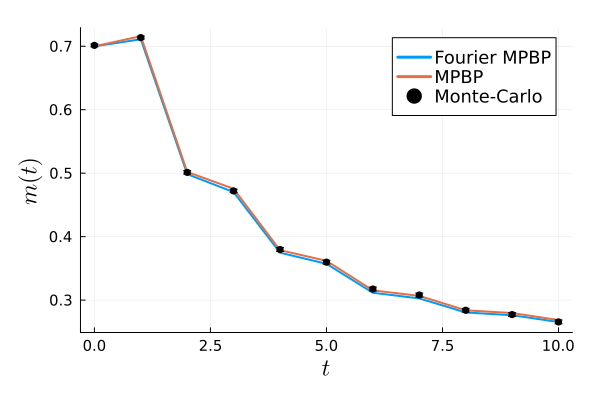

In [6]:
i = 2
y_mc = m_mc[i]
err_mc = σ_mc[i]
y_fourier = m_fourier[i]

T = length(y_fourier) - 1
plba = plot(legend=:topright, margin=5Plots.mm,
            xlabelfontsize=16,
            ylabelfontsize=16,
            legendfontsize=12,
            tickfontsize=10,
            size=(600,400),
            xlabel=L"t",
            ylabel=L"m(t)")

plot!(plba, 0:T, y_fourier[1:end], lw=2, label="Fourier MPBP")
plot!(plba, 0:T, m[i,1:end], lw=2, label="MPBP")
plot!(plba, 0:T, y_mc[1:end], yerr=err_mc, c=:black, st=:scatter, marker=:dot, label="Monte-Carlo")

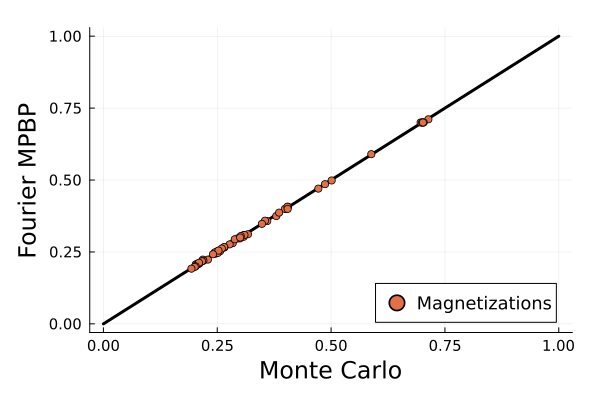

In [7]:
y_fourier_sc = reduce(vcat, y for y in m_fourier)
y_mc_sc = reduce(vcat, y for y in m_mc)
pl2ba = plot(legend=:bottomright, margin=5Plots.mm,
            xlabelfontsize=16,
            ylabelfontsize=16,
            legendfontsize=12,
            tickfontsize=10,
            size=(600,400),
            xlabel="Monte Carlo",
            ylabel="Fourier MPBP")

plot!(pl2ba, 0.0:0.1:1.0, 0.0:0.1:1.0, label="", c=:black, lw=3)
plot!(pl2ba, y_mc_sc, y_fourier_sc, st=:scatter, markerstrokecolor=:black, label="Magnetizations")

## Population dynamics

In [39]:
T = 6
k = 3
m⁰ = 0.6
β = 0.3

popsize = 4
d = 10
maxiter = 30
K = 100
σ = 1/100

ϕᵢ = [t == 0 ? [(1-m⁰)/2, (1+m⁰)/2] : ones(2) for t in 0:T]
ψ_neutral = [ones(2,2) for t in 0:T]

prob_degree = Dirac(k)
prob_J = Dirac(1.0)
prob_h = Dirac(0.0)

wᵢ = fill(HomogeneousGlauberFactor(rand(prob_J), rand(prob_h), β), T+1)
prob_w(w; d) = w

wᵢ_fourier = fill(FourierGlauberFactor([rand(prob_J) for _ in 1:k], rand(prob_h), β; K, σ, P), T+1)
prob_w_fourier(w; d) = w
;

In [40]:

μ_pop = map(1:popsize) do p
    μ = rand_mpem2(2, 2, T)
    normalize!(μ)
    μ
end |> AtomicVector
bs = Vector{Vector{Float64}}[] |> AtomicVector
bs2times =  Matrix{Matrix{Float64}}[] |> AtomicVector

μ_pop_fourier = map(1:popsize) do p
    μ = rand_mpem2(ComplexF64, 2, 2, T)
    normalize!(μ)
    μ
end |> AtomicVector
bs_fourier = Vector{Vector{Float64}}[] |> AtomicVector
bs2times_fourier =  Matrix{Matrix{Float64}}[] |> AtomicVector

function stats!(statvecs, wᵢ, μ, μin, b, f)
    @assert length(statvecs) == 2
    (bs, bs2times) = statvecs
    belief = [real.(m) for m in marginals(b)]
    belief2times = [real.(m) for m in twovar_marginals(b)]
    push!(bs, belief)
    push!(bs2times, belief2times)
end


iterate_popdyn!(μ_pop, wᵢ, prob_degree, prob_w, (bs, bs2times); ϕ=ϕᵢ, maxiter, svd_trunc=TruncBond(d), stats=stats!)
iterate_popdyn!(μ_pop_fourier, wᵢ_fourier, prob_degree, prob_w_fourier, (bs_fourier, bs2times_fourier); ϕ=ϕᵢ, maxiter, svd_trunc=TruncBond(d), stats=stats!)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:10:06


In [41]:
Nmc = 5*10^3
g = random_regular_graph(Nmc, k) |> IndexedBiDiGraph
J = 1.0
h = 0.0
w_mc = [fill(HomogeneousGlauberFactor(J*β, h*β), T+1) for i in vertices(g)]
bp_mc = mpbp(Float64, g, w_mc, fill(2, nv(g)), T; ϕ = fill(ϕᵢ, Nmc))
sms = SoftMarginSampler(bp_mc)

X = zeros(Int, Nmc, T+1)
autocorrs_mc = [zeros(T+1) for _ in 1:Nmc]
means_mc = [zeros(T+1) for _ in 1:Nmc]
energy_mc = zeros(T)

nsamples = 10^4
@showprogress for samp in 1:nsamples
    onesample!(X, bp_mc)
    for i in 1:Nmc
        autocorrs_mc[i] .+= potts2spin.(X[i,:]) .* potts2spin(X[i,end])
        means_mc[i] .+= potts2spin.(X[i,:])
    end
end

autocorrs_mc ./= nsamples
means_mc ./= nsamples
autocorrs_mc .-= means_mc .* [x[end] for x in means_mc]
autocorr_mc = mean([abs.(x) for x in autocorrs_mc])
m_mc = mean(means_mc)
;

Progress:  85%|██████████████████████████████████▋      |  ETA: 0:00:24Excessive output truncated after 524418 bytes.

In [42]:
import MatrixProductBP.Models: potts2spin
ns = 20
range = length(bs)+1-min(ns, length(bs)):length(bs)
ms = [expectation.(potts2spin, b) for b in bs[range]]
m = mean(ms)
σ = std(ms) ./ sqrt(length(ms))
range_fourier = length(bs_fourier)+1-min(ns, length(bs_fourier)):length(bs_fourier)
ms_fourier = [expectation.(potts2spin, b) for b in bs_fourier[range_fourier]]
m_fourier = mean(ms_fourier)
σ_fourier = std(ms_fourier) ./ sqrt(length(ms_fourier))

rs = [expectation.(potts2spin, btu) for btu in bs2times[range]]
cs = MatrixProductBP.covariance.(rs, ms)
c_avg = mean(abs.(x) for x in cs)
c_std = std(cs) ./ sqrt(length(cs))
rs_fourier = [expectation.(potts2spin, btu) for btu in bs2times_fourier[range_fourier]]
cs_fourier = MatrixProductBP.covariance.(rs_fourier, ms_fourier)
c_avg_fourier = mean(abs.(x) for x in cs_fourier)
c_std_fourier = std(cs_fourier) ./ sqrt(length(cs_fourier))
;

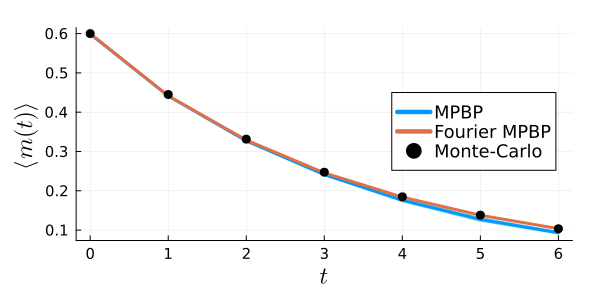

In [43]:
y_mc = m_mc
y = m
y_fourier = m_fourier

T = length(y_fourier) - 1
plrr = plot(legend=:right, margin=5Plots.mm,
            xlabelfontsize=16,
            ylabelfontsize=16,
            legendfontsize=12,
            tickfontsize=10,
            size=(600,300),
            xlabel=L"t",
            ylabel=L"\langle m(t) \rangle")

plot!(plrr, 0:T, y[1:end], ribbon=σ, lw=3, label="MPBP")
plot!(plrr, 0:T, y_fourier[1:end], ribbon=σ_fourier, lw=3, label="Fourier MPBP")
plot!(plrr, 0:T, y_mc[1:end], c=:black, st=:scatter, marker=:dot, markersize=5, label="Monte-Carlo")
display(plrr)

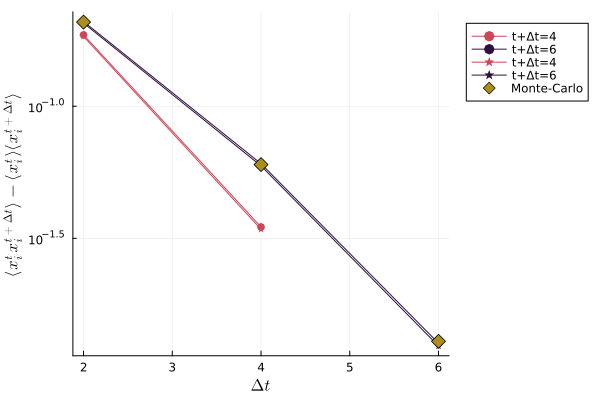

In [47]:
plot_autocovs(args...; kw...) = plot_autocovs!(plot(), args...; kw...)
function plot_autocovs!(pl, c; skip_even=false, T=size(c,1)-1, us = 0:(2*floor(Int, T/10)):T, kw...)
    step = skip_even ? 2 : 1
    cg = cgrad(:matter, length(us)+1, categorical=true)
    ylabel = L"\langle x_{i}^t x_{i}^{t+\Delta t}\rangle-" * 
        L"\langle x_{i}^t\rangle\langle x_{i}^{t+\Delta t}\rangle"
    xlabel = L"\Delta t"
    plot!(pl; xlabel, ylabel, legend=:outertopright)
     
    for (j,u) in enumerate(us)
        plot!(pl, u:-step:1, c[1:step:u,u+1], label="t+Δt=$u", c=cg[j+1], msc=:auto; kw...)
    end
    pl
end
pl = plot_autocovs(c_avg; skip_even=true, m=:o, us=4:2:T, yaxis=:log)
plot_autocovs!(pl, c_avg_fourier; skip_even=true, m=:star5, us=4:2:T)

plot!(pl, T:-2:2, autocorr_mc[1:2:end-1], st=:scatter, marker=:diamond, markersize=7, label="Monte-Carlo")

plot!()